In [1]:
import os
import glob
import math
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from ruamel.yaml import YAML
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
sns.set(font_scale=1.3, font="Times New Roman")

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def _parse_function(file):
    features = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'audio_inputs': tf.io.FixedLenFeature([], tf.string),
        'scene': tf.io.FixedLenFeature([], tf.string),
        'source_file': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_features = tf.io.parse_single_example(file, features=features)
    label = tf.cast(parsed_features['label'], tf.int64)
    source_file = tf.io.decode_raw(parsed_features['source_file'], tf.uint8)
    return label, source_file

def get_input_fn(filenames, batch_size):
    def _input_fn():
        dataset = tf.data.TFRecordDataset(filenames)
        dataset = dataset.map(_parse_function)
        dataset = dataset.batch(batch_size)
        iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
        # There are a couple of elements here. 
        next_element = iterator.get_next()
        return next_element
    return _input_fn

def data_meta_parse(yaml_file):
    with open(yaml_file) as f:
        yaml = YAML(typ='safe')
        yaml_map = yaml.load(f)
        set_dict = dict()
        for file_dict in yaml_map:
            set_dict[file_dict['mixture_audio_filename']] = dict_to_object(file_dict)
        return set_dict
    
class dict_to_object(object):
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            setattr(self, k, v)

    def __str__(self):
        return "\n".join(["{} : {}".format(k,v) for k,v in self.__dict__.items()])

In [3]:
def sep_eval_on_ebr(scene_name, model, model_name):
    data_dir = ''
    evaltest_dir = os.path.join(data_dir,"data/TUT-rare-sound-events-2017-evaluation/data",
        "mixture_data/evaltest/bbb81504db15a03680a0044474633b67")
    test_meta_dir = os.path.join(evaltest_dir,"meta")
    test_meta_dir_file = os.path.join(test_meta_dir,"mixture_recipes_evaltest_")
    b_test_meta = data_meta_parse(test_meta_dir_file+"babycry.yaml")
    gs_test_meta = data_meta_parse(test_meta_dir_file+"gunshot.yaml")
    gb_test_meta = data_meta_parse(test_meta_dir_file+"glassbreak.yaml")  
    filenames = [os.path.join(data_dir, 'data_binaries/test/babycry/{}/babycry_{}_pos.tfrecord'.format(scene_name,scene_name)), 
                 os.path.join(data_dir, 'data_binaries/test/babycry/{}/babycry_{}_neg.tfrecord'.format(scene_name,scene_name)), 
                 os.path.join(data_dir, 'data_binaries/test/glassbreak/{}/glassbreak_{}_pos.tfrecord'.format(scene_name,scene_name)), 
                 os.path.join(data_dir, 'data_binaries/test/glassbreak/{}/glassbreak_{}_neg.tfrecord'.format(scene_name,scene_name)), 
                 os.path.join(data_dir, 'data_binaries/test/gunshot/{}/gunshot_{}_pos.tfrecord'.format(scene_name,scene_name)), 
                 os.path.join(data_dir, 'data_binaries/test/gunshot/{}/gunshot_{}_neg.tfrecord'.format(scene_name,scene_name))]
    input_fn_test = get_input_fn(filenames, 1)
    labels_op, meta_op = input_fn_test()
    test_meta = {**b_test_meta, **gs_test_meta, **gb_test_meta}

    preds = np.load(os.path.join(data_dir, 
                                 'preds/test_preds_{}/preds_test_{}_{}.npy'.format(model, model_name, scene_name)))
    targets = np.load(os.path.join(data_dir,
                                   'targets/targets_{}/targets_test_{}_{}.npy'.format(model, model_name, scene_name)))
    preds = np.squeeze(preds)
    targets = np.squeeze(targets)

    mse = ((preds-targets)**2).mean(axis=1)

    label_list = []
    ebr_list = []

    neg = [['mse', 'label', 'ebr']]
    mid = []
    high = []
    low = []
    i = 0
    with  tf.compat.v1.Session() as sess:
        while True:
            try:
                label, meta = sess.run([labels_op, meta_op])
                # Deserialise (was stored as an int)
                meta_str = ''.join(chr(i) for i in meta[0])
                try:
                    # Get name of file and check the event-to-backround-ratio of this meta file. 
                    ebr = test_meta['_'.join(meta_str.split('_')[:-1])+'.wav'].ebr
                except KeyError:
                    print('File meta not found')
                    break
                if label == 1:
                    # db are floats. 
                    if math.isclose(ebr,0):
                        mid.append([mse[i], label[0], ebr])
                    elif ebr < 0:
                        low.append([mse[i], label[0], ebr])
                    elif ebr > 0:
                        high.append([mse[i], label[0], ebr])
                else:
                    neg.append([mse[i], label[0], ebr])
                i+=1
                label_list.append(label[0])
            except tf.errors.OutOfRangeError:
                break
    low_full = neg + low
    mid_full = neg + mid
    high_full = neg + high
    
    df_low = pd.DataFrame(low_full[1:], columns=low_full[0])
    df_mid = pd.DataFrame(mid_full[1:], columns=mid_full[0])
    df_high = pd.DataFrame(high_full[1:], columns=high_full[0])
    
    low_fpr, low_tpr, _ = roc_curve(df_low['label'].values, df_low['mse'].values)
    auc_low = auc(low_fpr, low_tpr)
    
    mid_fpr, mid_tpr, _ = roc_curve(df_mid['label'].values, df_mid['mse'].values)
    auc_mid = auc(mid_fpr, mid_tpr)

    high_fpr, high_tpr, _ = roc_curve(df_high['label'].values, df_high['mse'].values)
    auc_high = auc(high_fpr, high_tpr)

    fpr, tpr, _ = roc_curve(label_list, mse)
    auc_com = auc(fpr,tpr)
    return auc_low, auc_mid, auc_high, auc_com

In [4]:
scenes = (
    "beach",
    "bus",
    "cafe_restaurant",
    "car",
    "city_center",
    "forest_path",
    "grocery_store",
    "home",
    "library",
    "metro_station",
    "office",
    "park",
    "residential_area",
    "train",
    "tram"
)

auc_neg_6dB_wn = []
auc_0dB_wn = []
auc_pos_6dB_wn = []
auc_com_wn = []

for scene_name in scenes:
    auc_low_wn, auc_mid_wn, auc_high_wn, auc_all_wn = sep_eval_on_ebr(scene_name, 'wavenet', "WaveNet")
    auc_neg_6dB_wn.append(auc_low_wn)
    auc_0dB_wn.append(auc_mid_wn)
    auc_pos_6dB_wn.append(auc_high_wn)
    auc_com_wn.append(auc_all_wn)
    print('Processed scene {} for WaveNet.'.format(scene_name))

Processed scene beach for WaveNet.
Processed scene bus for WaveNet.
Processed scene cafe_restaurant for WaveNet.
Processed scene car for WaveNet.
Processed scene city_center for WaveNet.
Processed scene forest_path for WaveNet.
Processed scene grocery_store for WaveNet.
Processed scene home for WaveNet.
Processed scene library for WaveNet.
Processed scene metro_station for WaveNet.
Processed scene office for WaveNet.
Processed scene park for WaveNet.
Processed scene residential_area for WaveNet.
Processed scene train for WaveNet.
Processed scene tram for WaveNet.


In [5]:
auc_com_wn

[0.7249212353262138,
 0.8287052631578948,
 0.7561466229663864,
 0.8217299387792277,
 0.8236671102689241,
 0.7175636189877798,
 0.7716451089573134,
 0.6905454425988069,
 0.6662959154254813,
 0.790010652017652,
 0.7841212117390216,
 0.8038107366043231,
 0.777699619439862,
 0.8382276824461414,
 0.8695021100364341]

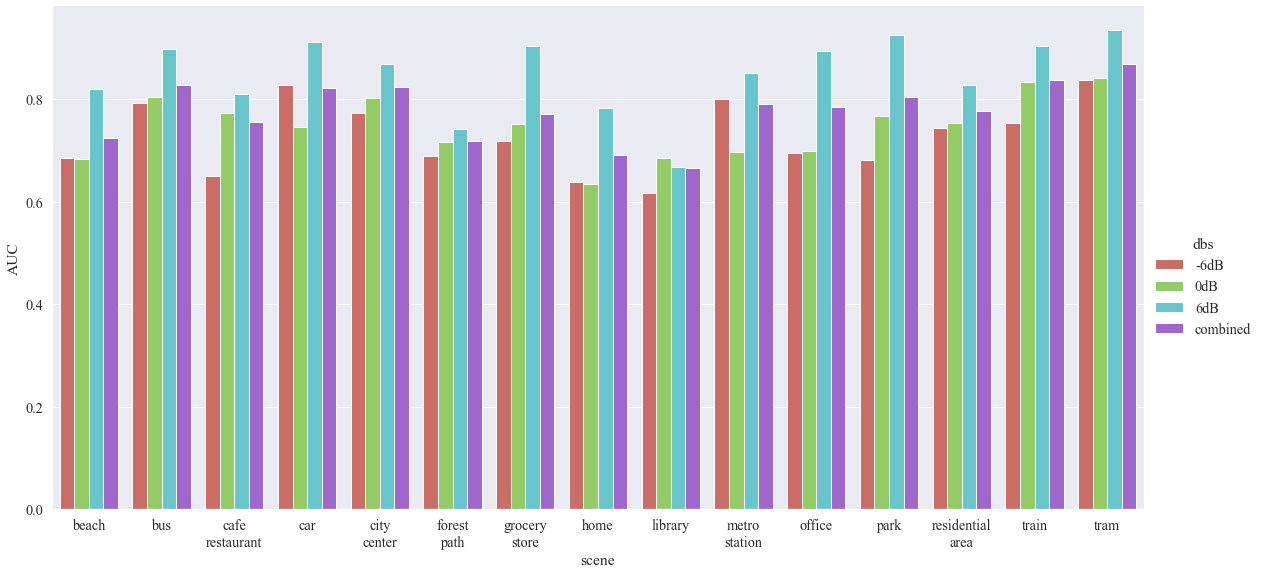

In [6]:
scene_list = [scene.replace('_', '\n') for scene in scenes]
scene_list = scene_list*4 # Create 15 scenes for each snr score. 
dbs_wn = np.concatenate([np.full(len(auc_neg_6dB_wn), '-6dB'),
                      np.full(len(auc_0dB_wn), '0dB'),
                      np.full(len(auc_pos_6dB_wn), '6dB'),
                      np.full(len(auc_com_wn), 'combined')
                     ])
auc_scores_wn =  auc_neg_6dB_wn+auc_0dB_wn+auc_pos_6dB_wn+auc_com_wn
plot_data_wn = {'scene': scene_list, 
     'dbs': dbs_wn ,
     'AUC':auc_scores_wn} 

df_wn = pd.DataFrame(data=plot_data_wn)
wn_plot=sns.catplot(x='scene', y='AUC', hue='dbs', data=df_wn, kind='bar', height=8, aspect=2,palette=sns.color_palette("hls", 4))
wn_plot.savefig("wavenet_snr_ROCAUC.png")


In [7]:
auc_neg_6dB_cae = []
auc_0dB_cae = []
auc_pos_6dB_cae = []
auc_com_cae = []

for scene_name in scenes:
    auc_low_cae, auc_mid_cae, auc_high_cae, auc_all_cae = sep_eval_on_ebr(scene_name,'cae','CAE')
    auc_neg_6dB_cae.append(auc_low_cae)
    auc_0dB_cae.append(auc_mid_cae)
    auc_pos_6dB_cae.append(auc_high_cae)
    auc_com_cae.append(auc_all_cae)
    print('Processed scene {} for CAE.'.format(scene_name))

Processed scene beach for CAE.
Processed scene bus for CAE.
Processed scene cafe_restaurant for CAE.
Processed scene car for CAE.
Processed scene city_center for CAE.
Processed scene forest_path for CAE.
Processed scene grocery_store for CAE.
Processed scene home for CAE.
Processed scene library for CAE.
Processed scene metro_station for CAE.
Processed scene office for CAE.
Processed scene park for CAE.
Processed scene residential_area for CAE.
Processed scene train for CAE.
Processed scene tram for CAE.


In [8]:
auc_com_cae

[0.6942539539938926,
 0.7929294414196411,
 0.6925009523016172,
 0.7896839815949859,
 0.751457434700052,
 0.6545196343519264,
 0.7050269513862195,
 0.6898417472535412,
 0.586443300797961,
 0.7429961169649938,
 0.7796394913934745,
 0.6985115740822218,
 0.7343311785037272,
 0.8230979782799646,
 0.8045354121379408]

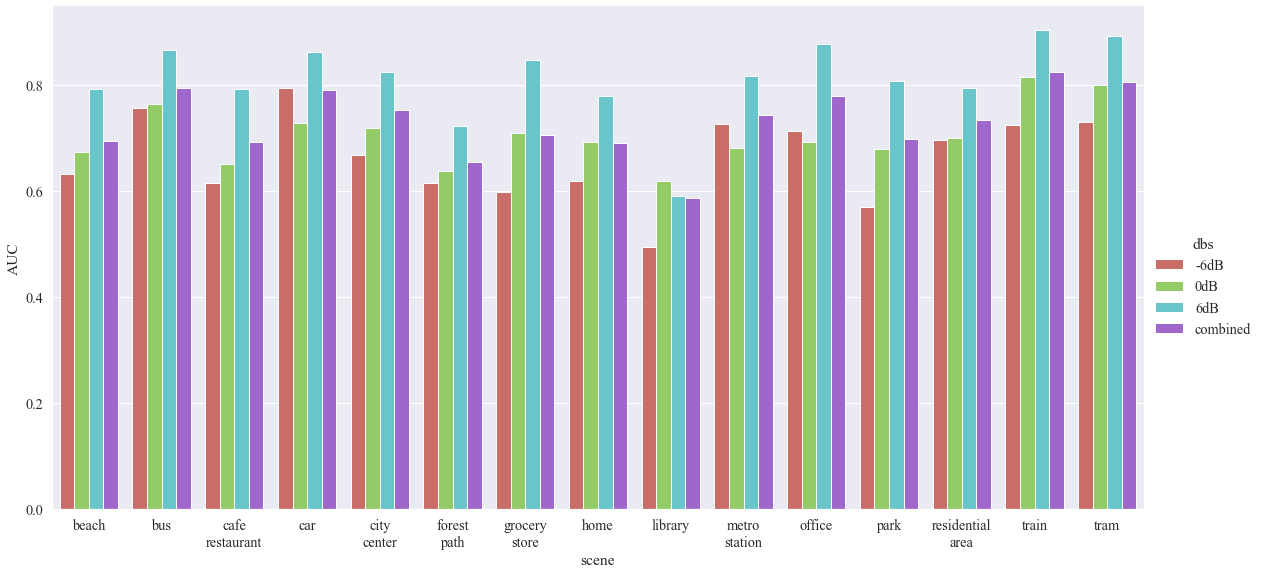

In [9]:

dbs_cae = np.concatenate([np.full(len(auc_neg_6dB_cae), '-6dB'),
                      np.full(len(auc_0dB_cae), '0dB'),
                      np.full(len(auc_pos_6dB_cae), '6dB'),
                      np.full(len(auc_com_cae), 'combined')
                     ])
auc_scores_cae =  auc_neg_6dB_cae+auc_0dB_cae+auc_pos_6dB_cae+auc_com_cae
plot_data_cae = {'scene': scene_list, 
     'dbs': dbs_cae ,
     'AUC':auc_scores_cae} 

df_cae = pd.DataFrame(data=plot_data_cae)
wn_plot = sns.catplot(x='scene', y='AUC', hue='dbs', data=df_cae, kind='bar', height=8, aspect=2,palette=sns.color_palette("hls", 4))
wn_plot.savefig("cae_snr_ROCAUC.png")

